Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [35]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')
from glob import glob
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset


data_dir_train = pathlib.Path("D:/upgrad/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('D:/upgrad/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
#pip install tf-nightly

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

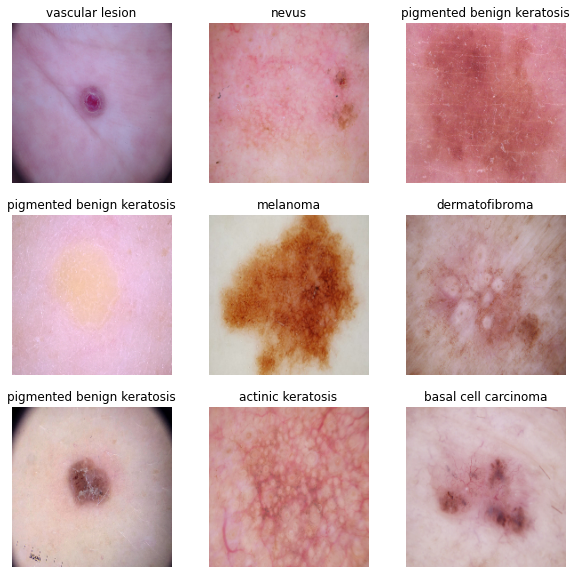

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here

num_classes = len(class_names)

model1 = Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./180, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
#  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [15]:
epochs = 25
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 91s 2s/step - loss: 2.0350 - accuracy: 0.2946 - val_loss: 1.9693 - val_accuracy: 0.2774
Epoch 2/25
56/56 [==============================] - 61s 1s/step - loss: 1.7122 - accuracy: 0.3956 - val_loss: 1.6166 - val_accuracy: 0.4385
Epoch 3/25
56/56 [==============================] - 68s 1s/step - loss: 1.4942 - accuracy: 0.4648 - val_loss: 1.4871 - val_accuracy: 0.4922
Epoch 4/25
56/56 [==============================] - 73s 1s/step - loss: 1.3860 - accuracy: 0.5006 - val_loss: 1.3955 - val_accuracy: 0.5190
Epoch 5/25
56/56 [==============================] - 69s 1s/step - loss: 1.2897 - accuracy: 0.5424 - val_loss: 1.4018 - val_accuracy: 0.5302
Epoch 6/25
56/56 [==============================] - 71s 1s/step - loss: 1.2642 - accuracy: 0.5441 - val_loss: 1.5128 - val_accuracy: 0.5034
Epoch 7/25
56/56 [==============================] - 69s 1s/step - loss: 1.1347 - accuracy: 0.6021 - val_loss: 1.6198 - val_accuracy: 0.4944
Epoch 8/25
56/56 [==

### Visualizing training results

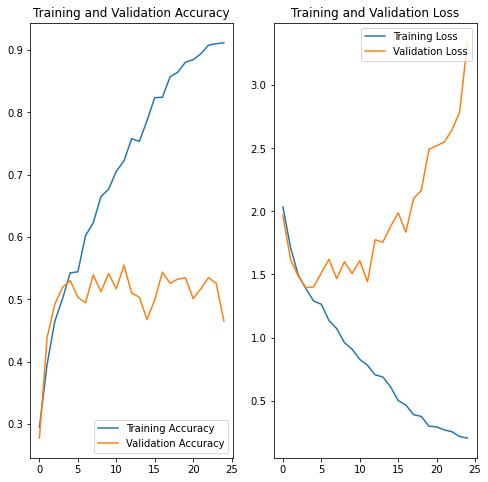

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


### Write your findings here

#### Model is giving 94% training accuracy whereas validation accuracy is way low.
#### This is a clear case of overfitting

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

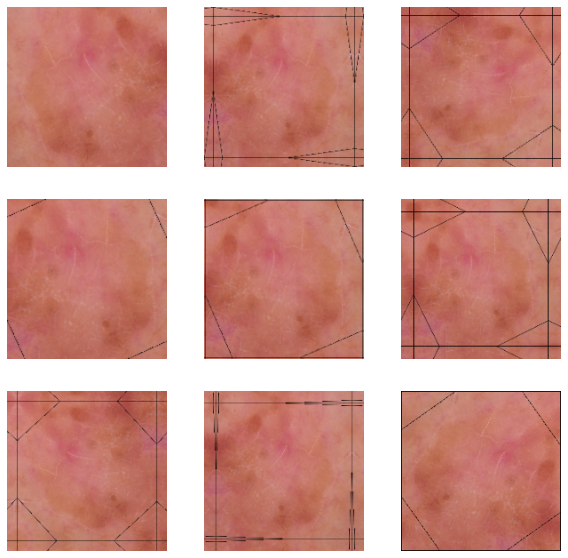

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model2 = Sequential([
  data_augmentation,
  tf.keras.layers.experimental.preprocessing.Rescaling(1./180),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
#  layers.Conv2D(128, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [20]:
## Your code goes here

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs

history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 [==============================] - 77s 1s/step - loss: 2.2378 - accuracy: 0.2160 - val_loss: 1.9635 - val_accuracy: 0.2931
Epoch 2/20
56/56 [==============================] - 83s 1s/step - loss: 1.9109 - accuracy: 0.3153 - val_loss: 1.7078 - val_accuracy: 0.3915
Epoch 3/20
56/56 [==============================] - 87s 2s/step - loss: 1.6519 - accuracy: 0.4068 - val_loss: 1.6058 - val_accuracy: 0.4541
Epoch 4/20
56/56 [==============================] - 85s 2s/step - loss: 1.4795 - accuracy: 0.4699 - val_loss: 1.4553 - val_accuracy: 0.4810
Epoch 5/20
56/56 [==============================] - 89s 2s/step - loss: 1.4160 - accuracy: 0.4872 - val_loss: 1.4336 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 96s 2s/step - loss: 1.3998 - accuracy: 0.4989 - val_loss: 1.4832 - val_accuracy: 0.4899
Epoch 7/20
56/56 [==============================] - 89s 2s/step - loss: 1.3839 - accuracy: 0.5089 - val_loss: 1.3436 - val_accuracy: 0.5324
Epoch 8/20
56/56 [==

### Visualizing the results

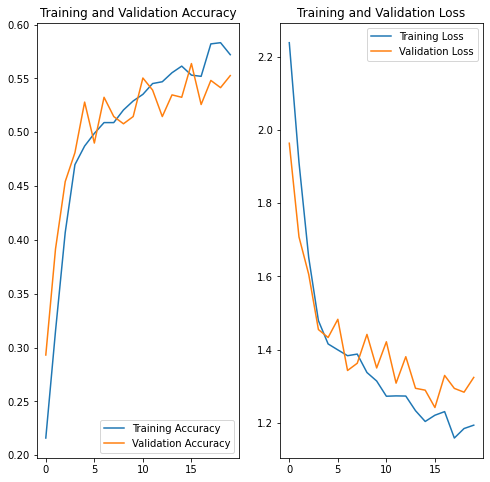

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs= 20

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

##### Model seems to be under fitting with data augmentation.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

actinic keratosis 114
basal cell carcinoma 376
dermatofibroma 95
melanoma 438
nevus 357
pigmented benign keratosis 462
seborrheic keratosis 77
squamous cell carcinoma 181
vascular lesion 139


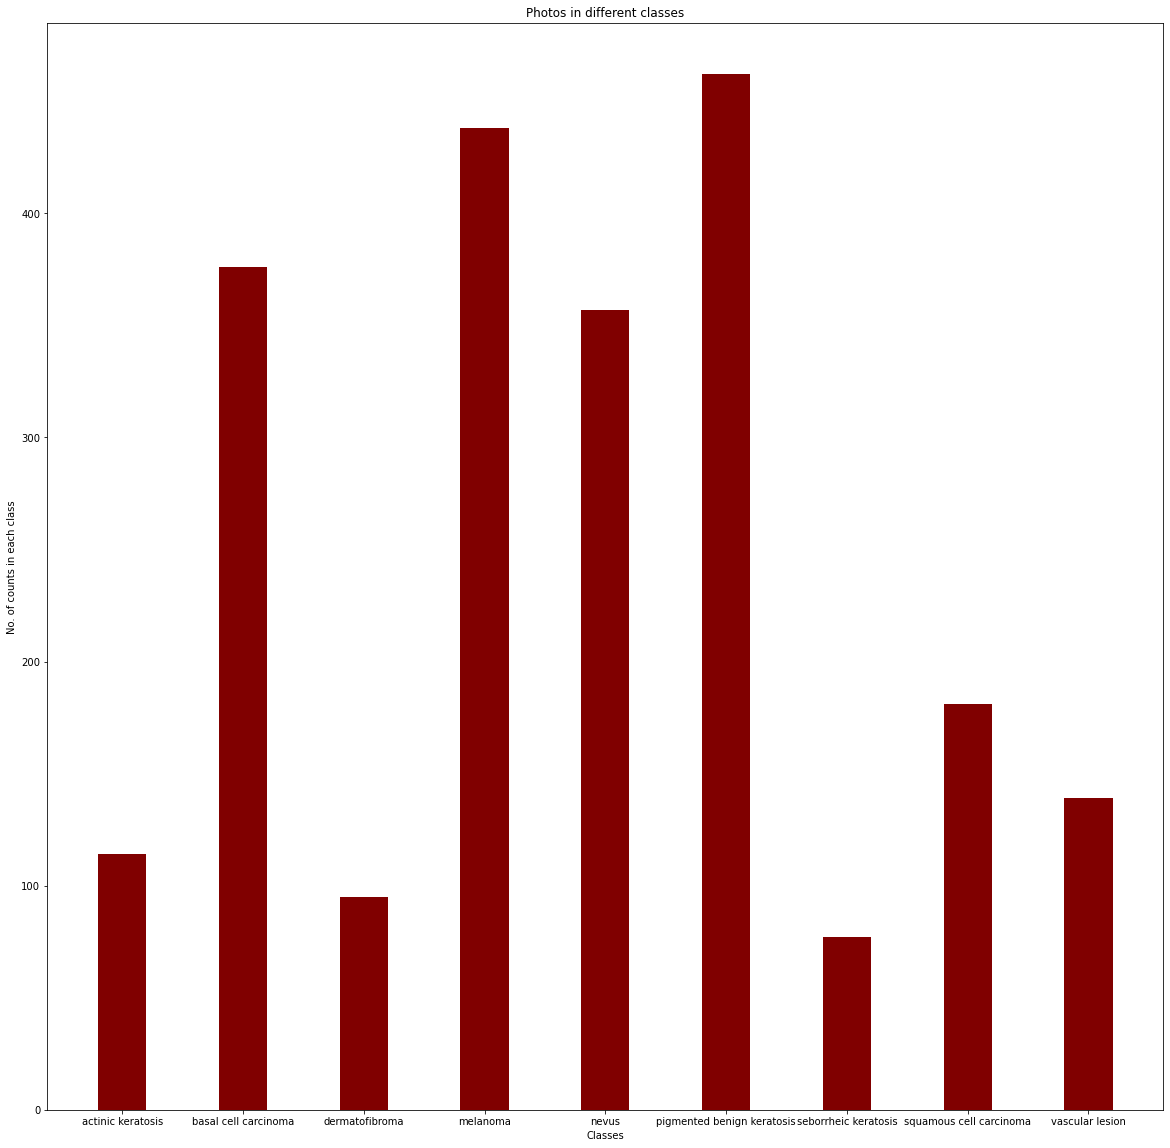

In [24]:
## Your code goes here.
count_classes = []
for classes in class_names:
    class_path= os.path.join(data_dir_train, classes)
    class_count = len(list(pathlib.Path(class_path).glob('*.jpg')))
    print(classes, class_count)
    count_classes.append(class_count)

#classes = list()
    
fig = plt.figure(figsize = (20, 20))
 
    # creating the bar plot
plt.bar(class_names, count_classes, color ='maroon',
        width = 0.4)
 
plt.xlabel("Classes")
plt.ylabel("No. of counts in each class")
plt.title("Photos in different classes")
plt.show()

#### **Todo:** Write your findings here: 
##### Train dataset is clearly imbalanced. All 9 classes have differrent number of samples and it may lead to biased behaviour of the model

#### - Which class has the least number of samples?
##### - seborrheic keratosis - 77 samples

#### - Which classes dominate the data in terms proportionate number of samples?
##### - pigmented benign keratosis - 462 samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
##!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset= "D:/upgrad/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

import Augmentor
for i in class_names:
    print(i)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

actinic keratosis
Initialised with 114 image(s) found.
Output directory set to D:/upgrad/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1AB542A44E0>: 100%|█| 500/500 [01:12<00:00,  6.89 Samples/


basal cell carcinoma


Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to D:/upgrad/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1AB08109320>: 100%|█| 500/500 [00:13<00:00, 37.55 Samples/


dermatofibroma


Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to D:/upgrad/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1AB023DB710>: 100%|█| 500/500 [00:13<00:


melanoma


Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to D:/upgrad/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x1AB07C33860>: 100%|█| 500/500 [01:28<00:00,  5.67 Samples/


nevus


Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to D:/upgrad/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x1AB07B84DA0>: 100%|█| 500/500 [01:01<00:00,  8.14 Samples/


pigmented benign keratosis


Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to D:/upgrad/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1AB3FCB55C0>: 100%|█| 500/500 [00:13<00:00, 35.92 Samples/


seborrheic keratosis


Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to D:/upgrad/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1AB542BE4A8>: 100%|█| 500/500 [00:31<00:00, 15.99 Samples


squamous cell carcinoma


Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to D:/upgrad/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1AB07BC2DA0>: 100%|█| 500/500 [00:13<00:


vascular lesion


Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to D:/upgrad/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1AB023DB630>: 100%|█| 500/500 [00:13<00:00, 36.75 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list


['D:\\upgrad\\Assignments\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_13dc6d43-bf9d-4339-a650-59c0af4c56ef.jpg',
 'D:\\upgrad\\Assignments\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_50a633e4-1d8c-4637-ba85-9316e72782ee.jpg',
 'D:\\upgrad\\Assignments\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_cb325644-eb5c-4fcf-a29c-a5d7df4f30ab.jpg',
 'D:\\upgrad\\Assignments\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_a457e5ca-cca8-4fef-a98b-31f26e2d670c.jpg',
 'D:\\upgrad\\Assignments\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [39]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [46]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
pd.set_option('display.max_colwidth', None)
df2.Path.head()

0    D:\upgrad\Assignments\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output\actinic keratosis_original_ISIC_0025780.jpg_13dc6d43-bf9d-4339-a650-59c0af4c56ef.jpg
1    D:\upgrad\Assignments\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output\actinic keratosis_original_ISIC_0025780.jpg_50a633e4-1d8c-4637-ba85-9316e72782ee.jpg
2    D:\upgrad\Assignments\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output\actinic keratosis_original_ISIC_0025780.jpg_cb325644-eb5c-4fcf-a29c-a5d7df4f30ab.jpg
3    D:\upgrad\Assignments\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output\actinic keratosis_original_ISIC_0025803.jpg_a457e5ca-cca8-4fef-a98b-31f26e2d670c.jpg
4    D:\upgrad\Assignments\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output\actinic keratosis_original_ISIC_0025803.jpg_f8e470ff-ecee-42

In [44]:
df2['Label'].value_counts()

nevus                         500
dermatofibroma                500
pigmented benign keratosis    500
squamous cell carcinoma       500
seborrheic keratosis          500
actinic keratosis             500
basal cell carcinoma          500
melanoma                      500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [48]:
data_dir_train="D:/upgrad/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [49]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [50]:
## your code goes here

model3 = Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./180, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
#  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [51]:
## your code goes here

model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [52]:
epochs = 30
## Your code goes here, use 50 epochs.

history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 264s 2s/step - loss: 2.0405 - accuracy: 0.2394 - val_loss: 1.5159 - val_accuracy: 0.4217
Epoch 2/30
169/169 [==============================] - 207s 1s/step - loss: 1.3951 - accuracy: 0.4813 - val_loss: 1.2497 - val_accuracy: 0.5316
Epoch 3/30
169/169 [==============================] - 217s 1s/step - loss: 1.1133 - accuracy: 0.5974 - val_loss: 1.0894 - val_accuracy: 0.5932
Epoch 4/30
169/169 [==============================] - 215s 1s/step - loss: 0.9146 - accuracy: 0.6710 - val_loss: 0.9967 - val_accuracy: 0.6437
Epoch 5/30
169/169 [==============================] - 213s 1s/step - loss: 0.7341 - accuracy: 0.7391 - val_loss: 0.8622 - val_accuracy: 0.7164
Epoch 6/30
169/169 [==============================] - 218s 1s/step - loss: 0.6071 - accuracy: 0.7884 - val_loss: 0.8309 - val_accuracy: 0.7342
Epoch 7/30
169/169 [==============================] - 213s 1s/step - loss: 0.4823 - accuracy: 0.8340 - val_loss: 0.8118 - val_accuracy: 0.7691

#### **Todo:**  Visualize the model results

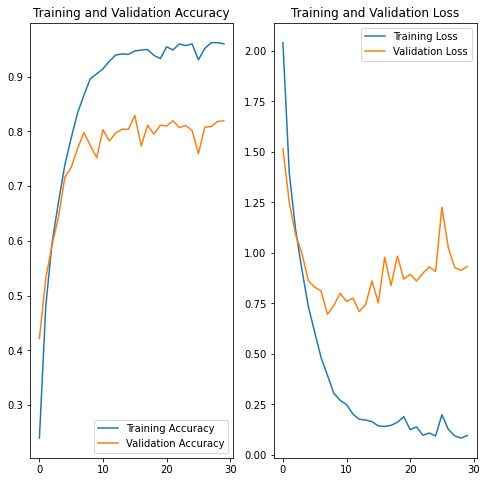

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

##### Using Augmenter did help in increasing overall accuracy and overfitting to some level.

##### We can tweak the model more and get validation accuracy close to training.


In [62]:
##  D:\upgrad\Assignments\Skin cancer ISIC The International Skin Imaging Collaboration\Test
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./180)

test_set = test_datagen.flow_from_directory('D:/upgrad/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration/Test',
                                                        target_size = (180, 180),
                                                        batch_size = 32,
                                                        class_mode = 'categorical')


Found 118 images belonging to 9 classes.


In [63]:
test_set.class_indices

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6,
 'squamous cell carcinoma': 7,
 'vascular lesion': 8}

In [78]:
from keras.preprocessing import image as image_utils

test_image = image_utils.load_img('D:/upgrad/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration/Test/basal cell carcinoma/ISIC_0024403.jpg', target_size=(180, 180))
test_image = image_utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

In [79]:
pred = model3.predict(test_image)
pred

array([[ 12.038346 ,  38.86523  ,   1.9535733,  -5.6569304,   1.57676  ,
         23.0888   , -33.653214 ,  -8.939078 , -20.318155 ]],
      dtype=float32)

In [80]:
print(pred.argmax())
for category, value in test_set.class_indices.items():
            if value == pred.argmax():
                print(category)

1
basal cell carcinoma
